**Užduotį atliko:**
Lukas Pupelis 2110612

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Dirbtinis neuronas su ADALINE mokymosi taisykle ir SGD

Neurono mokymui naudotas stochastinis gradientinis nusileidimas ir ADALINE mokymo taisyklė.

In [2]:
class AdalineSGD:
    # Konstruktorius su parametrais: mokymo greitis, epochų skaičius ir atsitiktinių skaičių generatoriaus pradinė padėtis.
    def __init__(self, learning_rate=0.01, epochs=50, random_state=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state # Atsitiktinių skaičių generatoriaus pradinė padėtis
        self.weights = None
        self.bias = None
        self.loss = []
        self.accuracy = []

    # Mokymo funkcija, kuri atnaujina svorius naudojant stochastinį gradientinį nusileidimą.
    def fit(self, X, y, E_min):
        rgen = np.random.RandomState(self.random_state) # Sukuriame atsitiktinių skaičių generatorių
        self.weights = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1]) # Inicializuojame svorius mažais atsitiktiniais skaičiais
        self.bias = 1.
        self.loss = []
        self.accuracy = []

        # Pradedame mokymo procesą, kuris vyks iki nurodyto epochų skaičiaus arba kol pasieksime minimalią paklaidą
        for epoch in range(self.epochs):
            X, y = shuffle(X, y, random_state=self.random_state)
            loss = 0

            # Iteruojame per kiekvieną mokymo duomenų pavyzdį
            for x, target in zip(X, y):
                output = self.neuron_input(x) # Apskaičiuojame neurono išvestį
                error = (target - output) # Apskaičiuojame paklaidą
                self.weights += self.learning_rate * x.dot(error) # Atnaujiname svorius
                self.bias += self.learning_rate * error
                loss += 0.5 * error**2 # Skaičiuojame paklaidos kvadratą ir jį pridedame prie bendros paklaidos
                

            avg_loss = loss / len(y)
            self.loss.append(avg_loss)
            self.accuracy.append(self.calculate_accuracy(X, y))
            if avg_loss <= E_min:  # Jeigu vidutinė paklaida mažesnė ar lygi nustatytam slenksiui, stabdome mokymo procesą
                print(f"Mokymasis sustabdytas {epoch+1} epochoje, nes pasiektas minimalus paklaidos slenkstis.")
                break

        return self

    # Funkcija, kuri apskaičiuoja bendrą svorių ir įvesties daugybą ir poslinkį.
    def neuron_input(self, X):
        return np.dot(X, self.weights) + self.bias

    # Prognozavimo funkcija, kuri klasifikuoja pateiktus duomenis kažkuriai klasei
    def predict(self, X):
        return np.where(self.neuron_input(X) >= 0.5, 1, 0)
    
    # Funkcija kuri skaičiuoja neurono prognozių tikslumą
    def calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy
    
    # Funkcija kuri skaičiuoja neurono prognozių vidutinę kvadratinę paklaidą
    def calculate_MSE(self, X, y):
        predictions = self.predict(X)
        errors = y - predictions
        mse = np.mean(errors**2)
        return mse

## Duomenų užkrovimas ir padalinimas į mokymosi ir testavimo aibes

In [3]:
# Funkcija, kuri užkrauna duomenis iš failo ir padalina į mokymosi ir testavimo aibes
def load_and_split_data(file_path, test_size=0.3):
    data = pd.read_csv(file_path, header=None, delimiter=';')
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)
    return X_train, X_test, y_train, y_test

## Pagalbinės funkcijos apskaičiuojančios metrikas

In [4]:
# Funkcija kiekvienam testavimo duomenų įrašui nurodyti, kokias klases nustatė neuronas ir kokia turėjo būti.
def test_data_evaluation(X_test, y_test, model):
    predictions = model.predict(X_test)
    print("Testavimo duomenų įrašų klasifikacija:")
    for i, (pred, actual) in enumerate(zip(predictions, y_test)):
        print(f"Įrašas {i+1}: Nustatyta klasė = {pred}, Turėjo būti = {actual}")

# Funkcija atliekanti eksperimentą ir apskaičiuojanti visas metrikas
def run_experiment(data_file_path, learning_rate, epochs, E_min):
    X_train, X_test, y_train, y_test = load_and_split_data(data_file_path)
    adaline = AdalineSGD(learning_rate=learning_rate, epochs=epochs)
    adaline.fit(X_train, y_train, E_min)

    epochs_range = range(1, len(adaline.loss) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, adaline.loss, color='red', label='Paklaida')
    plt.xlabel('Epocha')
    plt.ylabel('Paklaida')
    plt.title(f'Mokymosi greitis: {learning_rate}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, adaline.accuracy, color='blue', label='Tikslumas')
    plt.xlabel('Epocha')
    plt.ylabel('Tikslumas')
    plt.title(f'Mokymosi greitis: {learning_rate}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Epochų skaičius: {adaline.epochs}")
    print(f"Svoriai: {adaline.weights}")
    print(f"Poslinkis: {adaline.bias}")
    print(f"Mokymo duomenų tikslumas: {adaline.accuracy[-1]}")
    print(f"Mokymo duomenų paklaida: {adaline.loss[-1]}")
    print(f"Testavimo duomenų tikslumas: {adaline.calculate_accuracy(X_test, y_test)}")
    print(f"Testavimo duomenų paklaida: {adaline.calculate_MSE(X_test, y_test)}")
    print("\n\n")

    test_data_evaluation(X_test, y_test, adaline)

## Eksperimentas su irisų duomenimis

Eksperimentas su Irisų duomenimis:


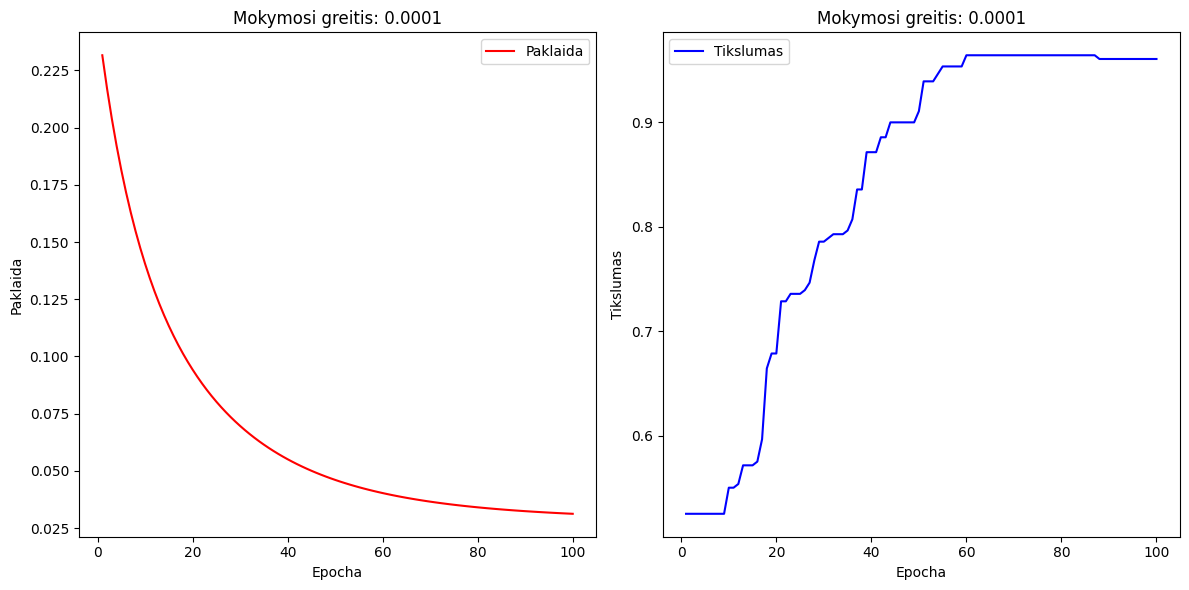

Epochų skaičius: 100
Svoriai: [-0.01227309 -0.07183678  0.19579716  0.26872893]
Poslinkis: 0.5363884624768477
Mokymo duomenų tikslumas: 0.9607142857142857
Mokymo duomenų paklaida: 0.031241516009056707
Testavimo duomenų tikslumas: 0.9416666666666667
Testavimo duomenų paklaida: 0.058333333333333334



Testavimo duomenų įrašų klasifikacija:
Įrašas 1: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 2: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 3: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 4: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 5: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 6: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 7: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 8: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 9: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 10: Nustatyta klasė = 0, Turėjo būti = 1
Įrašas 11: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 12: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 13: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 14: Nustatyta klasė = 1, Turėjo būti =

In [5]:
print("Eksperimentas su Irisų duomenimis:")
data_file_path = 'formatted_augmented_iris_data.csv'
learning_rate = 0.0001
epochs = 100
E_min = 0.01

run_experiment(data_file_path, learning_rate, epochs, E_min)

## Eksperimentas su krūties vėžio duomenimis

Eksperimentas su krūtų vėžio duomenimis:


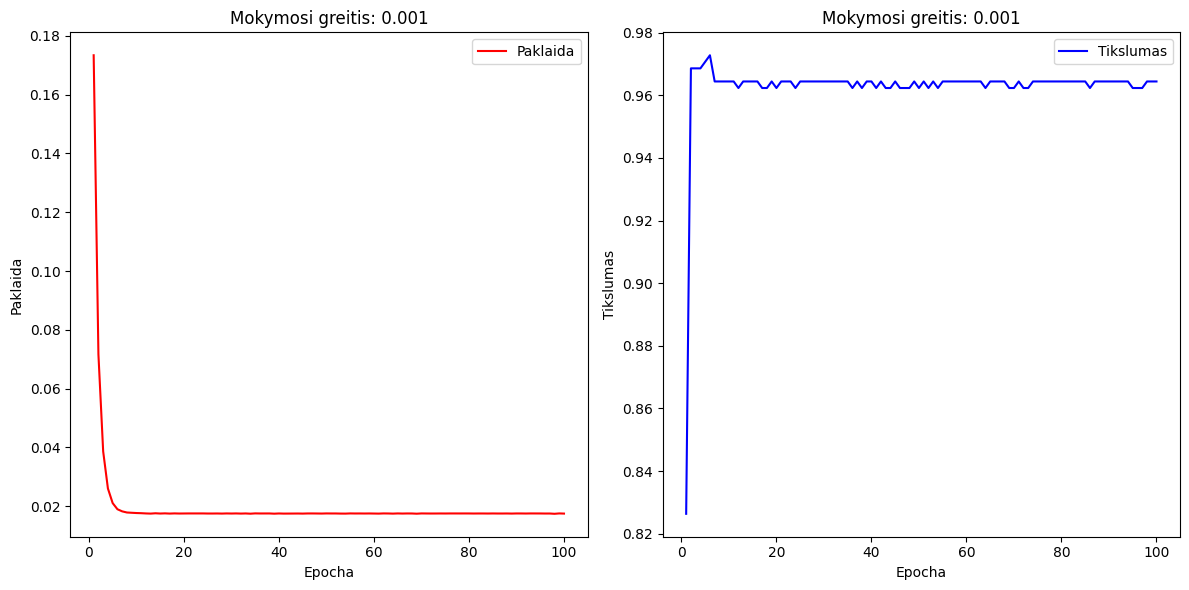

Epochų skaičius: 100
Svoriai: [0.09867365 0.03579249 0.05001816 0.02471733 0.03366868 0.16372938
 0.06031235 0.06170386 0.01170531]
Poslinkis: 0.35275509995479387
Mokymo duomenų tikslumas: 0.9644351464435147
Mokymo duomenų paklaida: 0.017494195663526585
Testavimo duomenų tikslumas: 0.9658536585365853
Testavimo duomenų paklaida: 0.03414634146341464



Testavimo duomenų įrašų klasifikacija:
Įrašas 1: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 2: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 3: Nustatyta klasė = 0, Turėjo būti = 1
Įrašas 4: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 5: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 6: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 7: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 8: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 9: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 10: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 11: Nustatyta klasė = 1, Turėjo būti = 1
Įrašas 12: Nustatyta klasė = 0, Turėjo būti = 0
Įrašas 13: Nustatyta klasė = 0, Turėjo bū

In [6]:
print("Eksperimentas su krūtų vėžio duomenimis:")
data_file_path = 'breast-cancer-data.csv'
learning_rate = 0.001
epochs = 100
E_min = 0.01

run_experiment(data_file_path, learning_rate, epochs, E_min)